# CS470/CS670 Team 6 Final Project: Proposal for Pneumonia Detection Using Chest X-Ray Images

In [ ]:
# Import required libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.keras.applications import MobileNetV2,ResNet50

# Suppress warnings
warnings.filterwarnings("ignore")


# 1. Load Dataset

In [ ]:
# Download dataset using kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print(f"Dataset downloaded to: {dataset_path}")

# Print directory structure
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)


100%|██████████| 2.29G/2.29G [01:46<00:00, 23.2MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Subdirectories: ['chest_xray']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Subdirectories: ['val', 'test', '__MACOSX', 'chest_xray', 'train']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
Subdirectories: ['PNEUMONIA', 'NORMAL']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val/PNEUMONIA
Subdirectories: []
Files: ['person1946_bacteria_4875.jpeg', 'person1946_bacteria_4874.jpeg', 'person1950_bacteria_4881.jpeg', 'person1952_bacteria_4883.jpeg', 'person1949_bacteria_4

#  2. Partition Images of Training and Test Data to Seperate Pandas Dataframes

In [ ]:
from sklearn.model_selection import train_test_split

def prepare_balanced_dataset(data_dir):
    filepaths, labels = [], []
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        for img_file in os.listdir(category_path):
            filepaths.append(os.path.join(category_path, img_file))
            labels.append(category)

    # Create a DataFrame
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})

    # Separate data by class
    pneumonia_df = df[df['label'] == 'PNEUMONIA']
    normal_df = df[df['label'] == 'NORMAL']

    # Get the minimum count between both classes
    min_count = min(len(pneumonia_df), len(normal_df))

    # Randomly sample the same number of images from both classes
    pneumonia_df = pneumonia_df.sample(min_count, random_state=123)
    normal_df = normal_df.sample(min_count, random_state=123)

    # Combine and shuffle the dataset
    balanced_df = pd.concat([pneumonia_df, normal_df]).sample(frac=1, random_state=123).reset_index(drop=True)

    # Split into train and test datasets (50:50 split)
    train_df, test_df = train_test_split(balanced_df, test_size=0.5, stratify=balanced_df['label'], random_state=123)

    return train_df, test_df

# Call the updated function
train_dir = os.path.join(dataset_path, "chest_xray/train")
test_dir = os.path.join(dataset_path, "chest_xray/test")

df_train, df_test = prepare_balanced_dataset(train_dir)

# Verify the distribution
print(f"Training Data:\n{df_train['label'].value_counts()}")
print(f"Testing Data:\n{df_test['label'].value_counts()}")


Training Data:
label
PNEUMONIA    671
NORMAL       670
Name: count, dtype: int64
Testing Data:
label
NORMAL       671
PNEUMONIA    670
Name: count, dtype: int64


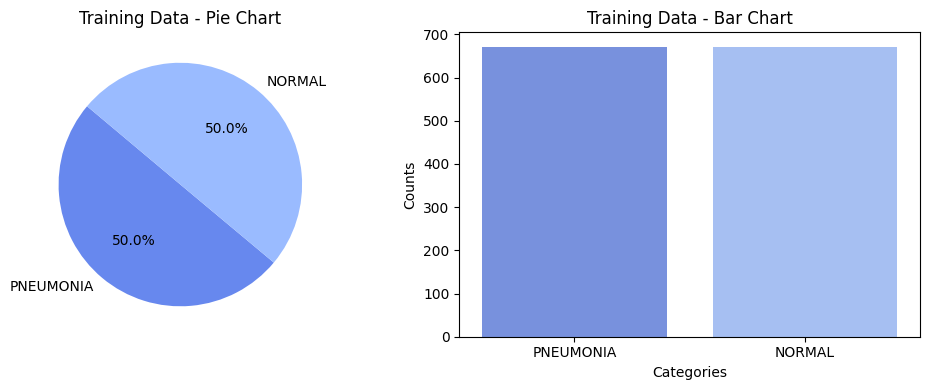

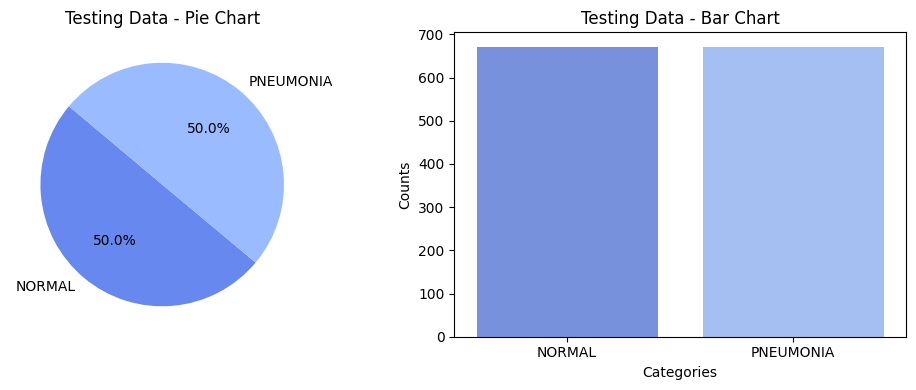

In [ ]:
# Visualize label distribution
def plot_label_distribution(df, title):
    label_counts = df['label'].value_counts()
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), facecolor='white')
    palette = sns.color_palette("coolwarm")

    # Pie chart
    axs[0].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
    axs[0].set_title(f'{title} - Pie Chart')

    # Bar chart
    sns.barplot(x=label_counts.index, y=label_counts.values, ax=axs[1], palette=palette)
    axs[1].set_title(f'{title} - Bar Chart')
    axs[1].set_xlabel('Categories')
    axs[1].set_ylabel('Counts')

    plt.tight_layout()
    plt.show()

plot_label_distribution(df_train, "Training Data")
plot_label_distribution(df_test, "Testing Data")


# 3. Preprocessing

In [ ]:
# Image dimensions and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# Create datasets
train_dataset = image_dataset_from_directory(
    train_dir, validation_split=0.1, subset="training", seed=123,
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
val_dataset = image_dataset_from_directory(
    train_dir, validation_split=0.1, subset="validation", seed=123,
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
test_dataset = image_dataset_from_directory(
    test_dir, seed=123, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)

# Normalize pixel values
def normalize_dataset(ds):
    return ds.map(lambda x, y: (x / 255.0, y))

train_dataset = normalize_dataset(train_dataset)
val_dataset = normalize_dataset(val_dataset)
test_dataset = normalize_dataset(test_dataset)


Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
#Preprocessing V2 - With Data augmentation techniques

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# Create data augmentation object
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    rotation_range=20,    # Rotate images randomly within 20 degrees
    width_shift_range=0.1,  # Shift horizontally by 10%
    height_shift_range=0.1,  # Shift vertically by 10%
    shear_range=0.1,       # Apply shearing
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Flip horizontally
    validation_split=0.1   # Reserve 10% of training data for validation
)

# Load augmented training data
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Use binary mode for binary classification
    subset='training',    # Training subset
    seed=123              # Ensure reproducibility
)

# Load validation data (no augmentation, just rescaling)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.1)
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=123
)

# Test dataset (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Do not shuffle for consistent evaluation
)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 4. Vizualization of Examples from Training Directory

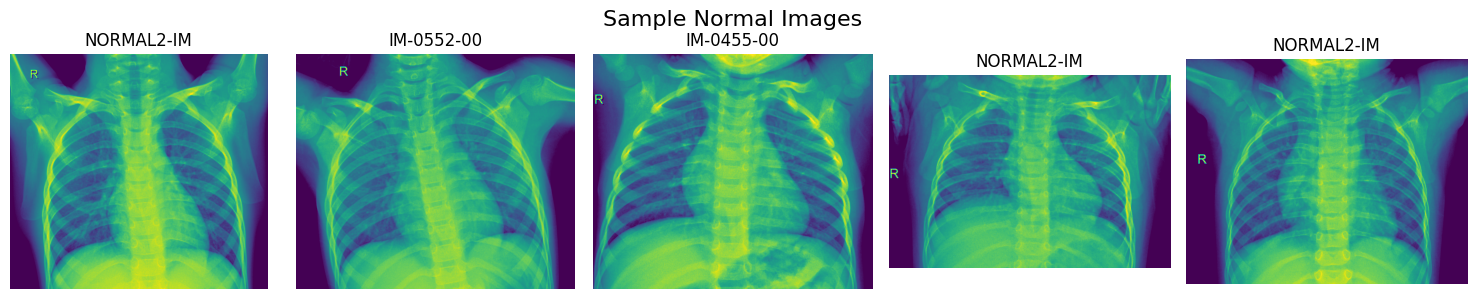

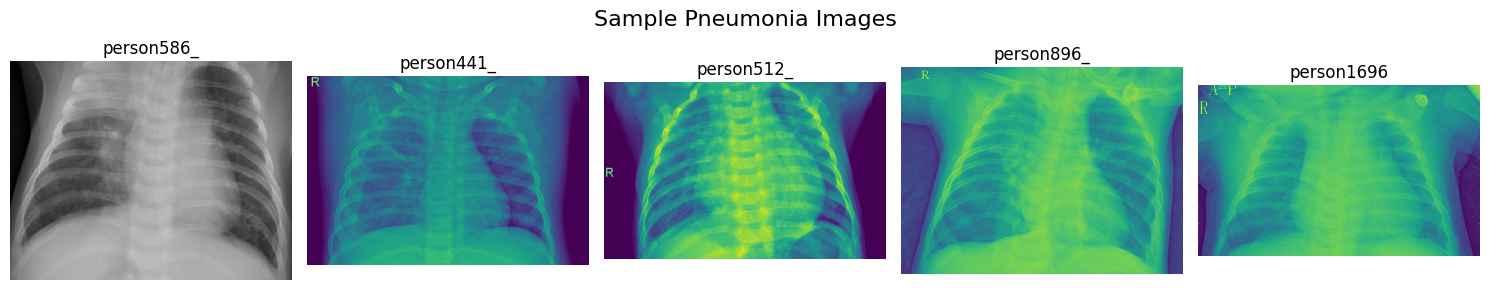

In [ ]:
# Visualize images from a given directory
def visualize_sample_images(data_dir, title, num_images=5):
    image_paths = os.listdir(data_dir)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    for i, img_file in enumerate(image_paths):
        img = plt.imread(os.path.join(data_dir, img_file))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(img_file[:10])  # Show partial filename
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_sample_images(os.path.join(train_dir, "NORMAL"), "Sample Normal Images")
visualize_sample_images(os.path.join(train_dir, "PNEUMONIA"), "Sample Pneumonia Images")


In [ ]:
# TODO:
# 1. Add data augmentation
# 2. Load models and run training; consider using 0.1 per batch for validation
# 2a.   Visualization of training efficiency
# 3. Initial testing
# 3a.   Visualization of results


In [ ]:
# Plot training accuracy and loss
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')

    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axs[0].set_title('Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Loss plot
    axs[1].plot(history.history['loss'], label='Train Loss', color='blue')
    axs[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
    axs[1].set_title('Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


## ResNet50 Model

Below is the function we will use later for fine-tuning. But before that, we will utilize transfer learning, by adding a few trainable layers to the end of the ResNet50 model, and the layers in the ResNet model will be FROZEN and pretrained with "ImageNet" weights. Using model.summary(), we also display the underlying architecture of ResNet50, to give us an idea of which layers to unfreeze/freeze.

ImageNet is a super large dataset that ResNet50 is trained on, making the model by default trained for feature extraction. The added layers will take the extracted feature information, and tie it towards our dataset to to make a calculated prediction. This is the basic idea of transfer learning to my understanding.

-Ahmed

In [ ]:
# Unfreeze the last few layers of ResNet50
def fine_tune_resnet50_model(model, num_layers_to_unfreeze):
    base_model = model.layers[0]  # Extract the pre-trained ResNet50 base model
    for layer in base_model.layers[-num_layers_to_unfreeze:]:
        layer.trainable = True  # Unfreeze these layers

    # Compile the model again with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.00001),  # Fine-tuning requires a smaller learning rate
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 53s 297ms/step - accuracy: 0.7182 - loss: 1.2869 - val_accuracy: 0.8599 - val_loss: 0.3728
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 265ms/step - accuracy: 0.8508 - loss: 0.3324 - val_accuracy: 0.8868 - val_loss: 0.2724
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - accuracy: 0.8942 - loss: 0.2630 - val_accuracy: 0.8234 - val_loss: 0.3926
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.9054 - loss: 0.2288 - val_accuracy: 0.9443 - val_loss: 0.1645
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.9272 - loss: 0.1835 - val_accuracy: 0.9463 - val_loss: 0.1457
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.9486 - loss: 0.1423 - val_accuracy: 0.9539 - val_loss: 0.1329
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - accuracy: 0.9499 - loss: 0.1325 - val_accuracy: 0.9463 - val_loss: 0.1385
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.9490 - loss: 0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,920,133 (281.98 MB)

 Trainable params: 16,777,473 (64.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 33,554,948 (128.00 MB)

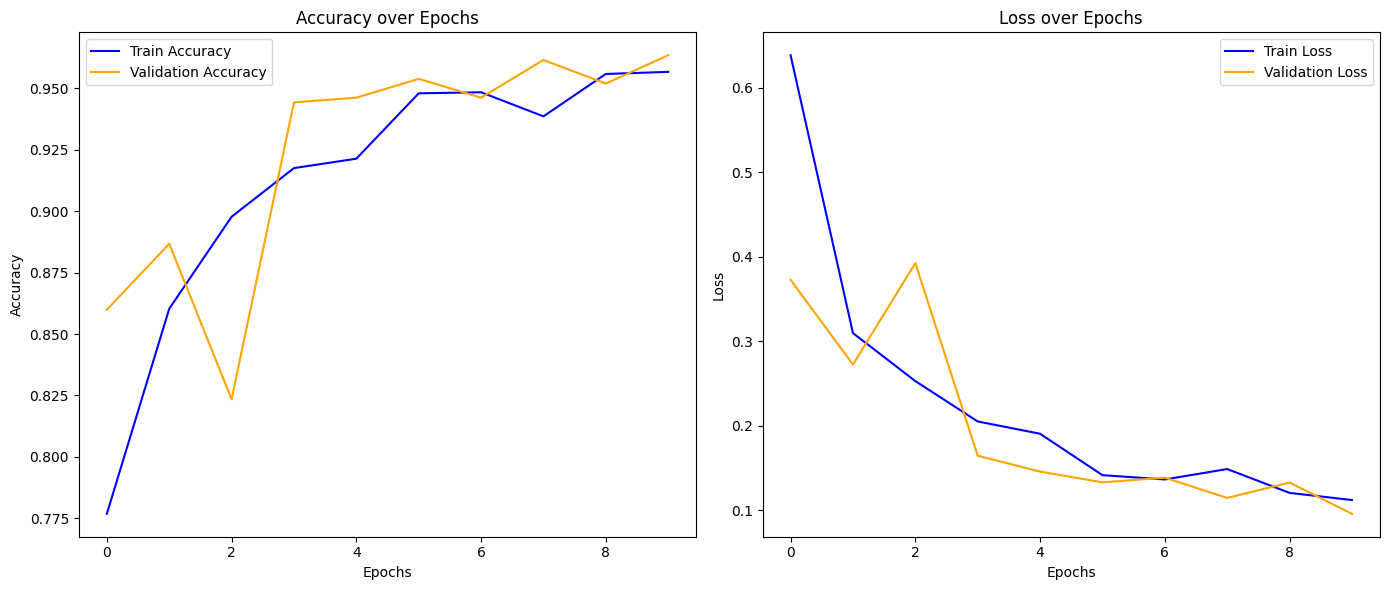

In [ ]:

def build_model(input_shape):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

    base_model.trainable = False  # freeze the base model (deeper layers to adapt these specific features to the pneumonia dataset)

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model((*IMAGE_SIZE, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping]
)
model.summary()
plot_training_history(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.7706 - loss: 0.5557
Test Accuracy: 0.75


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 61s 320ms/step - accuracy: 0.9258 - loss: 0.2992 - val_accuracy: 0.7639 - val_loss: 2.9356
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 270ms/step - accuracy: 0.9721 - loss: 0.0729 - val_accuracy: 0.7639 - val_loss: 2.8013
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.9710 - loss: 0.0752 - val_accuracy: 0.7639 - val_loss: 1.4711
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.9772 - loss: 0.0567 - val_accuracy: 0.9693 - val_loss: 0.0854
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 43s 278ms/step - accuracy: 0.9855 - loss: 0.0415 - val_accuracy: 0.9731 - val_loss: 0.0765
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 80s 262ms/step - accuracy: 0.9894 - loss: 0.0293 - val_accuracy: 0.9443 - val_loss: 0.1607
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - accuracy: 0.9790 - loss: 0.0575 - val_accuracy: 0.9789 - val_loss: 0.0799
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.9945 - loss: 0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,782,789 (350.12 MB)

 Trainable params: 25,708,801 (98.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

 Optimizer params: 51,417,604 (196.14 MB)

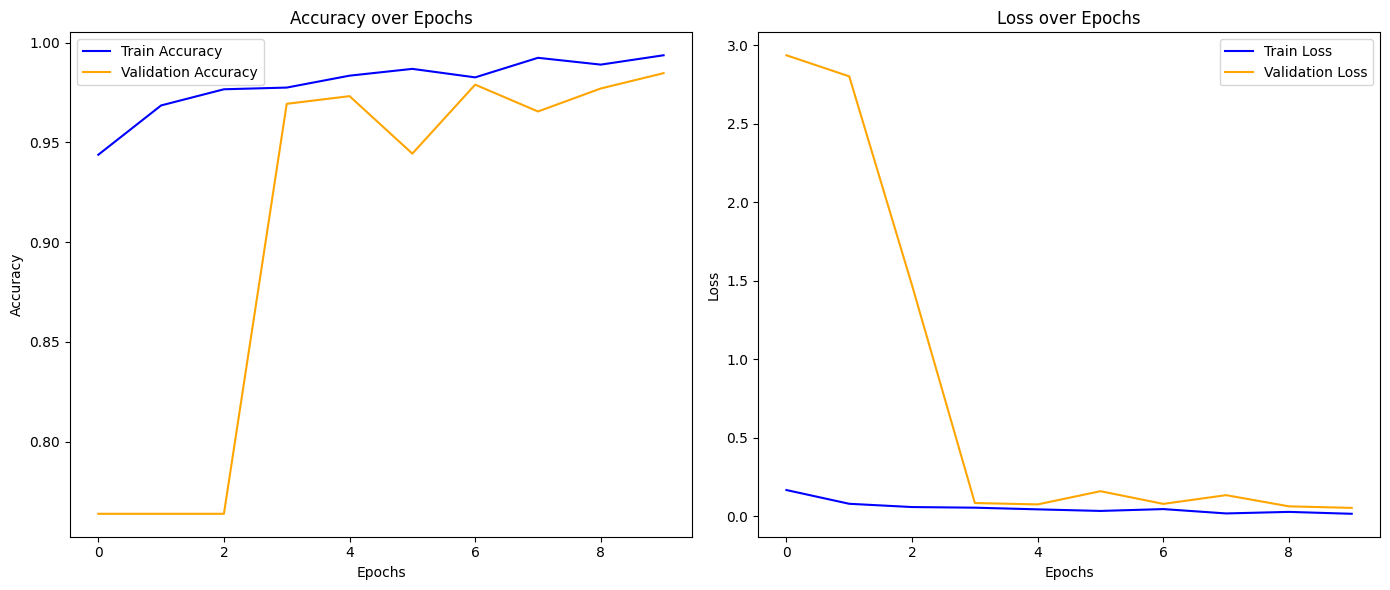

In [ ]:

#Finetuned model

model = fine_tune_resnet50_model(model, num_layers_to_unfreeze=20)

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping]
)
model.summary()
plot_training_history(history)


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.7099 - loss: 2.0530
Test Accuracy: 0.71
